In [1]:
#图片识别：植物病害识别
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time


In [2]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用CPU


In [3]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [4]:
src_base_path = Path('image')
dest_base_path = Path('images')
cats = ['黑斑病', '锈斑病','白粉病','炭疽病','闷根']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: 黑斑病
Total files: 84
Train set: 50 files
Valid set: 16 files
Test set: 18 files

Category: 锈斑病
Total files: 81
Train set: 48 files
Valid set: 16 files
Test set: 17 files

Category: 白粉病
Total files: 72
Train set: 43 files
Valid set: 14 files
Test set: 15 files

Category: 炭疽病
Total files: 111
Train set: 66 files
Valid set: 22 files
Test set: 23 files

Category: 闷根
Total files: 90
Train set: 54 files
Valid set: 18 files
Test set: 18 files

Overall Dataset Statistics:
Train set: 261 files
Valid set: 86 files
Test set: 91 files


In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64,seed = 42)



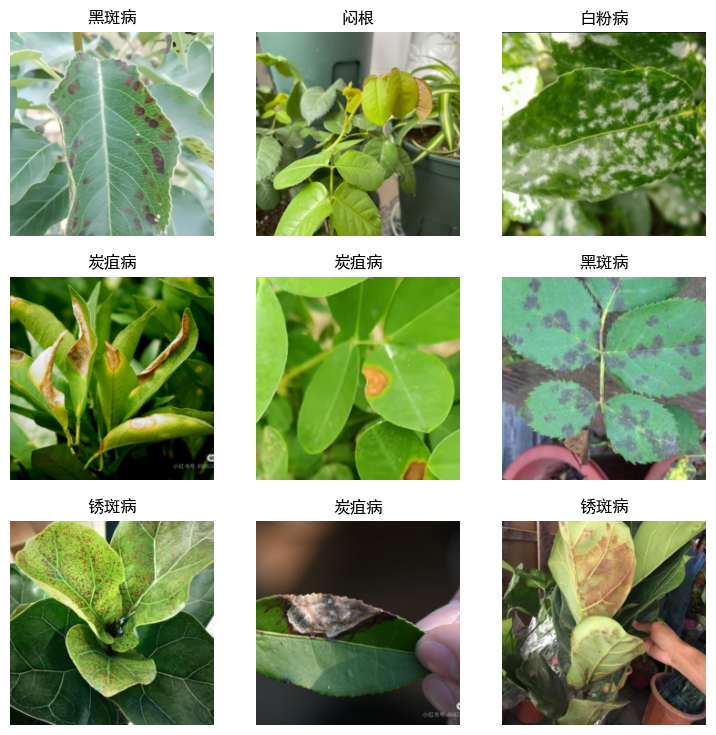

In [6]:
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
dls.show_batch()

In [7]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)
save_model_cb = SaveModelCallback(monitor='valid_loss')

learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])
# learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [8]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.877680,2.168275,0.320988,00:14


Better model found at epoch 0 with valid_loss value: 2.1682746410369873.


epoch,train_loss,valid_loss,accuracy,time
0,2.165434,1.534787,0.444444,00:18
1,1.920227,1.129520,0.543210,00:19
2,1.745890,0.926498,0.617284,00:18
3,1.582570,0.821321,0.691358,00:18
4,1.433328,0.757147,0.753086,00:18
5,1.312286,0.708228,0.753086,00:17
6,1.190642,0.669663,0.765432,00:17
7,1.065200,0.643807,0.765432,00:17
8,0.979589,0.616688,0.790123,00:17
9,0.899359,0.606566,0.790123,00:17


Better model found at epoch 0 with valid_loss value: 1.5347870588302612.
Better model found at epoch 1 with valid_loss value: 1.1295204162597656.
Better model found at epoch 2 with valid_loss value: 0.926498293876648.
Better model found at epoch 3 with valid_loss value: 0.8213214874267578.
Better model found at epoch 4 with valid_loss value: 0.7571465969085693.
Better model found at epoch 5 with valid_loss value: 0.7082279324531555.
Better model found at epoch 6 with valid_loss value: 0.66966313123703.
Better model found at epoch 7 with valid_loss value: 0.6438074707984924.
Better model found at epoch 8 with valid_loss value: 0.6166880130767822.
Better model found at epoch 9 with valid_loss value: 0.6065660119056702.
Better model found at epoch 10 with valid_loss value: 0.5972961783409119.
Better model found at epoch 11 with valid_loss value: 0.5891832709312439.
Better model found at epoch 13 with valid_loss value: 0.5841173529624939.
Better model found at epoch 14 with valid_loss valu

In [9]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.7058823704719543.


In [10]:
loss

0.9750913977622986

In [11]:
acc

0.7058823704719543

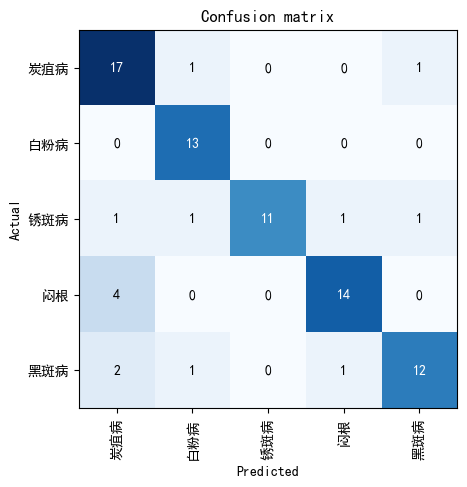

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
interp.print_classification_report()

              precision    recall  f1-score   support

         炭疽病       0.71      0.89      0.79        19
         白粉病       0.81      1.00      0.90        13
         锈斑病       1.00      0.73      0.85        15
          闷根       0.88      0.78      0.82        18
         黑斑病       0.86      0.75      0.80        16

    accuracy                           0.83        81
   macro avg       0.85      0.83      0.83        81
weighted avg       0.85      0.83      0.83        81



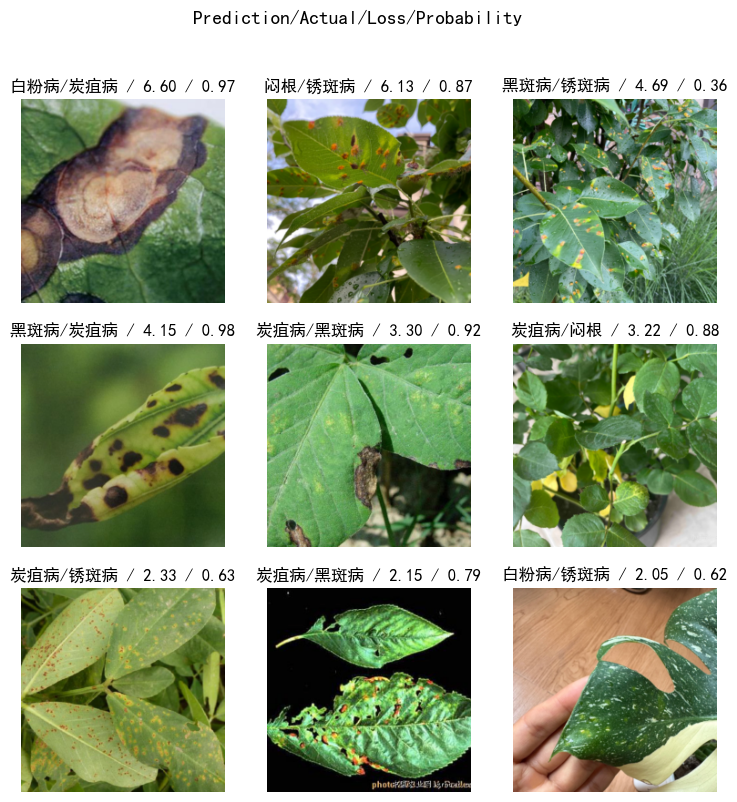

In [14]:
interp.plot_top_losses(9)

In [15]:
learn.export('植物病害识别.pkl')

In [16]:
from fastai.vision.all import * # 导入 fastai 视觉库的所有模块
from torchcam.methods import CAM, SmoothGradCAMpp # 从 torchcam 库导入 CAM 和 SmoothGradCAMpp 方法
from torchvision.transforms import Compose, Resize, ToTensor, Normalize # 从 torchvision 导入图像变换相关类
from torchvision.transforms.functional import to_pil_image # 从 torchvision.transforms.functional 导入将 Tensor 转换为 PIL 图像的函数
from PIL import Image # 导入 PIL 库用于图像处理
from torchcam.utils import overlay_mask # 从 torchcam 库导入用于叠加掩码的工具函数

In [17]:
def visualize_cam(learner, image_path, cam_class=SmoothGradCAMpp):
    """
    可视化指定图像的类激活图 (CAM)。

    参数:
        learner: fastai 的 Learner 对象，包含了训练好的模型。
        image_path (str): 需要可视化的图像文件路径。
        cam_class (type): 用于生成 CAM 的类，默认为 SmoothGradCAMpp。
    """
    # 加载图像文件，并确保图像是 RGB 格式
    img = Image.open(image_path).convert('RGB')

    # 定义一系列图像预处理步骤
    preprocess = Compose([
        Resize(224), # 将图像大小调整为 224x224 像素
        ToTensor(), # 将 PIL 图像转换为 PyTorch Tensor
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 使用 ImageNet 的均值和标准差对图像进行标准化
    ])

    # 应用预处理步骤到加载的图像上
    input_tensor = preprocess(img)
    # 在 Tensor 的第 0 维增加一个维度，以符合模型输入的 batch 要求 (batch_size=1)
    input_tensor = input_tensor.unsqueeze(0)

    # 从 Learner 对象中获取底层的 PyTorch 模型，并设置为评估模式 (eval mode)
    # 评估模式会关闭 dropout 和 batch normalization 的更新
    model = learner.model.eval()

    # 使用指定的 CAM 类初始化 CAM 提取器，并将其作为上下文管理器使用
    # 这样可以确保资源被正确管理
    with cam_class(model) as cam_extractor:
        # 将预处理后的图像 Tensor 输入模型，获取模型的输出分数 (logits)
        scores = model(input_tensor)

        # 从模型输出中移除 batch 维度，然后找到分数最高的那个类别的索引
        pred_class_idx = scores.squeeze(0).argmax().item()

        # 使用 CAM 提取器计算指定预测类别的激活图
        # cam_extractor 返回的是一个包含激活图的列表，我们取第一个元素
        activation_map = cam_extractor(pred_class_idx, scores)[0]

    # 将计算得到的激活图 (通常是单通道的浮点数 Tensor) 转换回 PIL 图像格式
    # mode='F' 表示输入是 32 位浮点数
    # .cpu() 是因为 to_pil_image 需要 CPU Tensor
    heatmap_pil = to_pil_image(activation_map.cpu(), mode='F')

    # 将生成的激活图 (热力图) 叠加到原始图像上
    # alpha 参数控制热力图的透明度
    overlayed_img = overlay_mask(img, heatmap_pil, alpha=0.5)

    # 创建一个新的 matplotlib 图形窗口来显示结果
    plt.figure(figsize=(6, 6)) # 可以调整图形大小
    # 显示叠加了热力图的图像
    plt.imshow(overlayed_img)
    # 设置图像标题，包含所使用的 CAM 方法的名称
    plt.title(f"{cam_class.__name__} 叠加效果")
    # 关闭坐标轴显示
    plt.axis('off')
    # 显示图形
    plt.show()
    # 防治建议逻辑
    try:
        treatment_df = pd.read_excel('防治.xlsx')
        pred_class = learner.predict(image_path)[0]
        print(f"\n🔍 识别结果: {pred_class}")
        
        if not treatment_df.empty:
            match = treatment_df[treatment_df['疾病'] == pred_class]
            if not match.empty:
                treatment = match.iloc[0]
                print(f"📝 症状描述: {treatment['症状']}")
                print("💊 推荐防治方案:")
                for i in range(1, 9):
                    remedy = treatment.get(f'防治{i}')
                    if pd.notna(remedy) and str(remedy).strip():
                        print(f"{i}. {remedy}")
            else:
                print("⚠️ 未找到该病害的防治方案")
    except Exception as e:
        print(f"⚠️ 数据加载失败: {str(e)}")


In [18]:
def visualize_random_images(learner, baifenbing_dir='images/test/白粉病', heibanbing_dir='images/test/黑斑病',mengen_dir='images/test/闷根',tanjubing_dir='images/test/炭疽病',xiubanbing_dir='images/test/锈斑病'):
    """
    随机选择并可视化相关植物图片的 CAM 效果。
    
    参数:
        learner: fastai 的 Learner 对象
        walle_dir (str): WALL-E 图片目录路径
        doraemon_dir (str): 哆啦A梦图片目录路径
    """
    # 获取文件夹中的图片文件
    baifenbing_images = os.listdir(baifenbing_dir)
    heibanbing_images = os.listdir(heibanbing_dir)
    mengen_images = os.listdir(mengen_dir)
    tanjubing_images = os.listdir(tanjubing_dir)
    xiubanbing_images = os.listdir(xiubanbing_dir)

       # 随机选择各病害样本
    baifenbing_image = random.choice(baifenbing_images)
    heibanbing_image = random.choice(heibanbing_images)
    mengen_image = random.choice(mengen_images)
    tanjubing_image = random.choice(tanjubing_images)
    xiubanbing_image = random.choice(xiubanbing_images)

    # 构建完整路径
    baifenbing_path = os.path.join(baifenbing_dir, baifenbing_image)
    heibanbing_path = os.path.join(heibanbing_dir, heibanbing_image)
    mengen_path = os.path.join(mengen_dir, mengen_image)
    tanjubing_path = os.path.join(tanjubing_dir, tanjubing_image)
    xiubanbing_path = os.path.join(xiubanbing_dir, xiubanbing_image)

    # 打印选择的图片路径
    print(f"随机选择的白粉病样本: {baifenbing_path}")
    print(f"随机选择的黑斑病样本: {heibanbing_path}") 
    print(f"随机选择的闷根样本: {mengen_path}")
    print(f"随机选择的炭疽病样本: {tanjubing_path}")
    print(f"随机选择的锈斑病样本: {xiubanbing_path}")

    # 可视化所有病害的CAM效果
    visualize_cam(learn, baifenbing_path)
    visualize_cam(learn, heibanbing_path)
    visualize_cam(learn, mengen_path)
    visualize_cam(learn, tanjubing_path)
    visualize_cam(learn, xiubanbing_path)



In [19]:
learn = load_learner('植物病害识别.pkl')

d:\CBY\CBYANACONDA\envs\datascience\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


随机选择的白粉病样本: images/test/白粉病\64.webp
随机选择的黑斑病样本: images/test/黑斑病\59.jpeg
随机选择的闷根样本: images/test/闷根\25.jpg
随机选择的炭疽病样本: images/test/炭疽病\81.jpg
随机选择的锈斑病样本: images/test/锈斑病\68.jpg


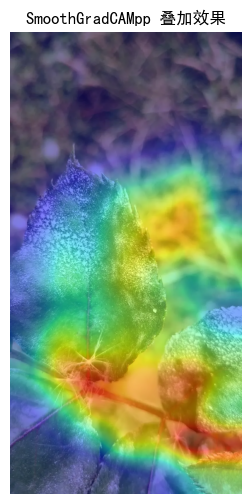


🔍 识别结果: 白粉病
📝 症状描述: 叶片、嫩茎、花蕾表面覆盖一层白色粉末状霉层（菌丝和孢子），后期病斑变为灰色，叶片扭曲、萎缩，植株生长受阻
💊 推荐防治方案:
1. 雨季或高温高湿季节前，喷施波尔多液（1:1:100）或石硫合剂（0.3-0.5 波美度），形成保护屏障
2. 用软布蘸取稀释的酒精（50%浓度）或小苏打溶液（5g小苏打+1L水）轻轻擦拭病叶，破坏菌丝结构
3. 戊唑醇（25%水乳剂2000倍液）或吡唑醚菌酯（25%悬浮剂1500倍液），内吸性强，可杀灭深层病菌


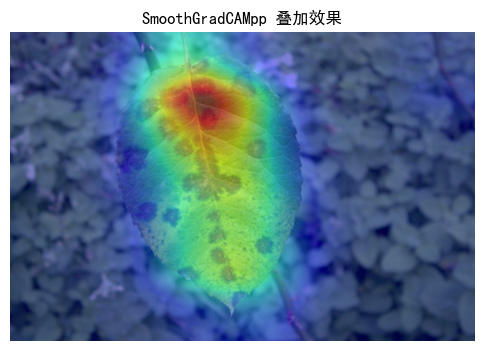


🔍 识别结果: 黑斑病
📝 症状描述: 叶片出现黑色圆形 ，不规则病斑，边缘泛黄，严重时落叶、植株枯萎
💊 推荐防治方案:
1. 将植物放置在通风良好、光照充足处，降低空气湿度，减少病菌滋生
2. 避免傍晚浇水或直接淋浇叶片，建议沿盆边浇灌，减少叶面湿度
3. 使用疏松透气的腐殖土，定期施用有机肥或均衡复合肥，增强植株抗病力
4. 定期对花盆、工具，用1% 硫酸铜溶液或多菌灵溶液消毒，避免交叉感染
5. 落叶植物入冬前清理枯枝落叶，喷施石硫合剂3-5波美度，杀灭越冬病菌
6. 单一药剂易导致病菌产生抗药性，建议保护性杀菌剂代森锰锌与治疗性杀菌剂戊唑醇交替使用
7. 用恶霉灵300倍液或甲基托布津500倍液浇灌根部，抑制土壤中的病菌
8. 使用苯醚甲环唑10%水分散粒剂1500倍液，每5-7天1次，连续3次


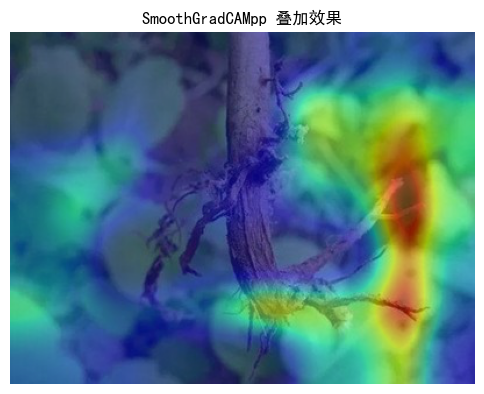


🔍 识别结果: 闷根
📝 症状描述: 根系缺氧腐烂，叶片萎蔫、发黄、无光泽，新叶卷曲，严重时整株枯萎，拔起植株可见根系变黑、腐烂，有酸臭味
💊 推荐防治方案:
1. 选用疏松透气的土壤，通用配方：腐叶土3份+珍珠岩2份+粗沙2份+有机肥1份
2. 花盆底部垫陶粒、碎瓦片或渗水层，避免底孔堵塞
3. 浇水前用手指插入土中 2-3cm，感觉干燥再浇透，避免频繁浇水
4. 冬季或阴雨天减少浇水频率，气温低时根系吸水慢，易积水闷根
5. 露养植物雨季及时搬入室内，避免盆土长期浸泡
6. 根系浸泡生根粉溶液（1000倍液）15分钟，晾干2-3小时后换新土上盆


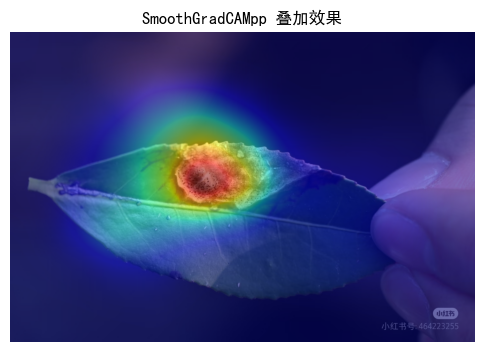


🔍 识别结果: 炭疽病
📝 症状描述: 叶片出现圆形或不规则形病斑，边缘深褐色，中间灰白色，湿度大时病斑上有粉红色黏状物（分生孢子），严重时叶片干枯、脱落
💊 推荐防治方案:
1. 保持通风透光，避免植株密集，降低空气湿度，炭疽病在高湿环境下易爆发
2. 浇水时避免淋浇叶片，沿盆边浇灌或使用滴灌，减少叶面湿润时间
3. 摘除病叶并销毁，剪口处涂抹草木灰或多菌灵粉末消毒
4. 苯醚甲环唑（10%水分散粒剂1500倍液）+丙环唑（25%乳油2000倍液），交替使用，每5-7天1次，连喷3次


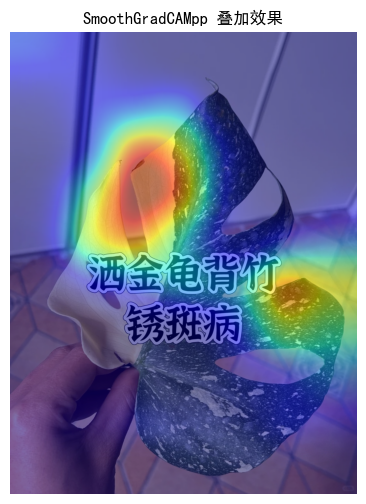


🔍 识别结果: 白粉病
📝 症状描述: 叶片、嫩茎、花蕾表面覆盖一层白色粉末状霉层（菌丝和孢子），后期病斑变为灰色，叶片扭曲、萎缩，植株生长受阻
💊 推荐防治方案:
1. 雨季或高温高湿季节前，喷施波尔多液（1:1:100）或石硫合剂（0.3-0.5 波美度），形成保护屏障
2. 用软布蘸取稀释的酒精（50%浓度）或小苏打溶液（5g小苏打+1L水）轻轻擦拭病叶，破坏菌丝结构
3. 戊唑醇（25%水乳剂2000倍液）或吡唑醚菌酯（25%悬浮剂1500倍液），内吸性强，可杀灭深层病菌


In [20]:
visualize_random_images(learn)

In [21]:
#植物推荐
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import torch

In [22]:
#一、用户冷启动  推荐系统冷启动数据处理（对应主程序hybrid_recommendation函数）
# 功能：加载植物特征数据，用于基于内容的推荐
# Step 1: 读取植物数据
df = pd.read_csv(
    'u.item',
    sep='|',
    header=None,
    names=[
        'plant_id', 'plant','好养护','价格实惠','款式多','生长速度快','耐旱','耐寒','耐阴','耐水','耐光耐晒','易开花','容易徒长泛滥','适合新手','易繁殖','风水价值','观赏价值','毒性成分','寓意美好','改善空气','缓解焦虑改善睡眠','用途广泛','抗病虫害','土壤要求严格','空间需求大','阳光要求高','水分要求高','花叶异味'


    ],
    encoding='utf-8'
)

In [23]:
df.head()

,plant_id,plant,好养护,价格实惠,款式多,生长速度快,耐旱,耐寒,耐阴,耐水,...,寓意美好,改善空气,缓解焦虑改善睡眠,用途广泛,抗病虫害,土壤要求严格,空间需求大,阳光要求高,水分要求高,花叶异味
0,1,多肉,1,1,1,1,1,1,1,0,...,1,0,0,0,1,0,0,0,0,0
1,2,玉树,1,1,1,1,1,0,1,1,...,1,0,0,1,1,0,0,0,0,0
2,3,婚礼油画吊兰,1,1,1,1,1,1,1,0,...,1,0,0,0,1,0,0,0,0,0
3,4,龟背竹,1,1,1,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
4,5,虎皮兰,1,1,1,1,1,1,1,1,...,1,0,0,1,1,0,0,0,0,0


In [24]:
# Step 2: 检查数据是否有缺失值
df.isnull().sum()

plant_id    0
plant       0
好养护         0
价格实惠        0
款式多         0
生长速度快       0
耐旱          0
耐寒          0
耐阴          0
耐水          0
耐光耐晒        0
易开花         0
容易徒长泛滥      0
适合新手        0
易繁殖         0
风水价值        0
观赏价值        0
毒性成分        0
寓意美好        0
改善空气        0
缓解焦虑改善睡眠    0
用途广泛        0
抗病虫害        0
土壤要求严格      0
空间需求大       0
阳光要求高       0
水分要求高       0
花叶异味        0
dtype: int64

In [25]:
# Step 3: 删除不必要的列，只保留植物ID和类别信息
df_no_title = df.drop(columns=['plant'] 
                                         )

In [26]:
df_no_title.head()

,plant_id,好养护,价格实惠,款式多,生长速度快,耐旱,耐寒,耐阴,耐水,耐光耐晒,...,寓意美好,改善空气,缓解焦虑改善睡眠,用途广泛,抗病虫害,土壤要求严格,空间需求大,阳光要求高,水分要求高,花叶异味
0,1,1,1,1,1,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,0
1,2,1,1,1,1,1,0,1,1,1,...,1,0,0,1,1,0,0,0,0,0
2,3,1,1,1,1,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,0
3,4,1,1,1,1,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,0
4,5,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,0,0,0,0,0


In [27]:
# Step 4: 计算植物之间的余弦相似度，生成一个相似度矩阵
item_similarity = cosine_similarity(df_no_title.drop(columns=['plant_id']))

In [28]:
item_similarity

array([[1.        , 0.8       , 0.93094934, ..., 0.86666667, 0.88852332,
        0.74535599],
       [0.8       , 1.        , 0.85933785, ..., 0.8       , 0.82928843,
        0.74535599],
       [0.93094934, 0.85933785, 1.        , ..., 0.85933785, 0.82717019,
        0.72057669],
       ...,
       [0.86666667, 0.8       , 0.85933785, ..., 1.        , 0.88852332,
        0.89442719],
       [0.88852332, 0.82928843, 0.82717019, ..., 0.88852332, 1.        ,
        0.79471941],
       [0.74535599, 0.74535599, 0.72057669, ..., 0.89442719, 0.79471941,
        1.        ]])

In [29]:
# Step 5: 测试1：找到 '多肉' 的 plant_id
favorite_plant_id = df[df['plant']=='多肉']['plant_id'].values[0]

In [30]:
#输出测试结果
favorite_plant_id

1

In [31]:
# Step 6: 测试2：找到最相似的绿植，按相似度从高到低排序
most_similar_plant = item_similarity[favorite_plant_id - 1].argsort()[::-1]

In [32]:
most_similar_plant

array([ 0,  5,  7, 58,  6, 59,  2, 31, 30, 47, 36, 37, 35, 11, 21, 17, 55,
       57, 70, 77, 64, 32,  3, 82, 10, 68, 69, 51, 81, 29,  4, 20, 72,  8,
       18, 67, 65, 73, 24, 25, 27, 63, 66, 46, 26, 39, 56, 43,  9, 19, 28,
       16, 41, 40, 42, 33, 14, 80, 62, 12, 13, 15, 75, 52,  1, 60, 38, 45,
       53, 54, 22, 23, 44, 50, 76, 74, 83, 48, 34, 78, 79, 49, 61, 71],
      dtype=int64)

In [33]:
# Step 7:测试3： 获取与 '多肉' 最相似的前5种绿植
similar_plant_titles = df.loc[most_similar_plant[1:6]]['plant']

In [34]:
# Step 8: 输出推荐结果
print(similar_plant_titles)

5      仙人球
7     落地生根
58     君子兰
6      太阳花
59     罗汉松
Name: plant, dtype: object


In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy

In [36]:
def build_trainset(df):
    """把 DataFrame 封成 Surprise 的 trainset。"""
    return Dataset.load_from_df(df[['user_id', 'plant_id', 'rating']], reader) \
                  .build_full_trainset()

In [37]:
def top_n(algo, user_id, n=5, items_df=None):
    # 获取所有植物ID的预测
    predictions = [algo.predict(user_id, item_id) for item_id in items_df['plant_id']]
    
    # 转换为DataFrame格式
    results = pd.DataFrame([(pred.iid, 
                            items_df.loc[items_df.plant_id==pred.iid, 'title'].iloc[0], 
                            round(pred.est, 4)) 
                          for pred in predictions],
                         columns=['plant_id', '植物名称', '预测评分'])
    
    return results.sort_values('预测评分', ascending=False).head(n)

In [38]:
def add_and_retrain(algo, ratings_df, new_ratings_df):
    updated = pd.concat([ratings_df, new_ratings_df], ignore_index=True)
    new_trainset = build_trainset(updated)
    algo.fit(new_trainset)
    return algo, updated

In [39]:
# ---------------- 0. 全局设置 ----------------
SEED = 42
np.random.seed(SEED)
DATA_DIR = Path('models')      # 根据需要修改

In [40]:
# ---------------- 1. 加载数据 ----------------
ratings_cols = ['user_id', 'plant_id', 'rating', 'timestamp']
ratings = pd.read_csv(
    DATA_DIR / 'u.data',
    sep='\t',
    names=ratings_cols,
    dtype={'user_id': 'int32', 'plant_id': 'int32',
           'rating': 'int8', 'timestamp': 'int32'}
)


In [41]:
ratings.head()

,user_id,plant_id,rating,timestamp
0,55,45,3,1002259248
1,121,30,2,1004377117
2,7,33,2,1005089177
3,139,73,2,1005647938
4,67,55,2,1006414676


In [42]:
plant_cols = ['plant_id', 'title']  
plant = pd.read_csv(
    DATA_DIR / 'u.item',
    sep='|',
    names=plant_cols,
    usecols=[0, 1],          # 只保留必需列
    encoding='utf-8',
    dtype={'plant_id': 'int32', 'title': 'string'}
)



In [43]:
# ---------------- 2. Surprise 数据集封装 ----------------
reader = Reader(rating_scale=(
    ratings.rating.min(),
    ratings.rating.max()
))

In [44]:
# 80/20 按时间序列切分
ratings_sorted = ratings.sort_values('timestamp')

In [45]:
split_idx = int(0.8 * len(ratings_sorted))
train_df, test_df = ratings_sorted[:split_idx],ratings_sorted[split_idx:]

In [46]:
trainset = build_trainset(train_df)
testset = list(test_df[['user_id',
                        'plant_id',
                        'rating']].itertuples(
                            index=False,
                            name=None
                        ))

In [47]:
# ---------------- 3. 训练 SVD ----------------
algo = SVD(random_state=SEED,
           n_factors=100,
           n_epochs=25)
algo.fit(trainset)

In [48]:
# ---------------- 4. 评估 ----------------
# 在模型训练后添加评估代码
from surprise import accuracy
import matplotlib.pyplot as plt

# 在测试集上评估
preds = algo.test(testset)
print(f'RMSE: {accuracy.rmse(preds, verbose=False):.4f}')
print(f'MAE : {accuracy.mae(preds,  verbose=False):.4f}')

RMSE: 1.5715
MAE : 1.2974


In [49]:
# ---------------- 5. 新用户冷启动 + 重训 ----------------
new_uid = ratings.user_id.max() + 1
# 安全查询方式
def get_plant_id(df, plant_name):
    results = df[df.title.str.contains(plant_name, case=False, na=False)]
    if not results.empty:
        return int(results.iloc[0].plant_id)
    raise ValueError(f"未找到包含'{plant_name}'的植物")

try:
    new_user_ratings = pd.DataFrame({
        'user_id': [new_uid, new_uid],
        'plant_id': [
            get_plant_id(plant, '玉树'),
            get_plant_id(plant, '太阳花')  
        ],
        'rating': [1,5],
        'timestamp': [ratings.timestamp.max() + 1] * 2
    })
except ValueError as e:
    print(f"错误: {e}")
    print("可用植物列表:", planet.title.unique().tolist())


In [50]:
algo, ratings = add_and_retrain(algo, ratings, new_user_ratings)
print(f"\n为新用户 {new_uid} 推荐：")
print(top_n(algo, user_id=new_uid, items_df=plant))  


为新用户 151 推荐：
    plant_id 植物名称    预测评分
6          7  太阳花  3.8631
61        62   文竹  3.3580
60        61  散尾葵  3.3081
17        18  朱顶红  3.3078
56        57  满天星  3.2415


RMSE: 0.9302
MAE:  0.7609

模型评估结果：
RMSE: 0.9302
MAE: 0.7609


<module 'matplotlib.pyplot' from 'd:\\CBY\\CBYANACONDA\\envs\\datascience\\Lib\\site-packages\\matplotlib\\pyplot.py'>

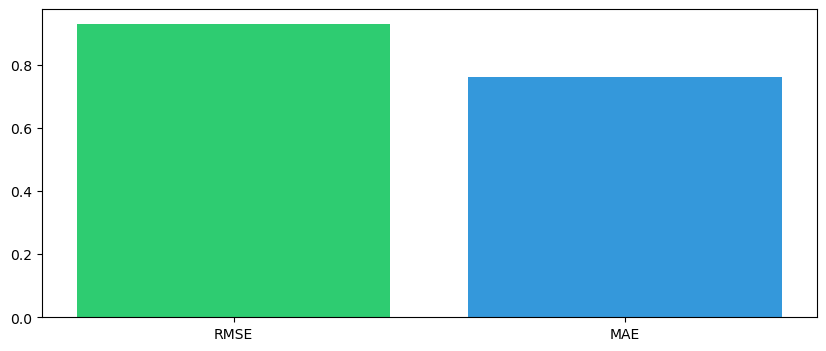

In [51]:
# 整体评估报告及可视化
from surprise import accuracy
import matplotlib.pyplot as plt

# 在测试集上评估
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# 计算评估指标
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# 打印格式化的评估结果
print(f"\n模型评估结果：")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# 可选的可视化代码
plt.figure(figsize=(10,4))
plt.bar(['RMSE', 'MAE'], [rmse, mae], color=['#2ecc71', '#3498db'])
plt

In [52]:
#二、协同过滤  #实现植物推荐系统的协同过滤部分，包含数据加载、模型训练、嵌入保存全流程
from fastai.tabular.all import *
from fastai.collab import *
from fastai.metrics import rmse, mae
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.optim import Adam
import os

In [53]:
def collab_pipeline():
    # 数据加载
    plants = pd.read_csv('u.item', sep='|', 
                       names=['plant_id', 'plant', '好养护', '价格实惠', '款式多'])
    ratings = pd.read_csv('u.data', sep='\t',
                        names=['user_id','plant_id','rating','timestamp'])
    
    # 创建数据加载器
    dls = CollabDataLoaders.from_df(ratings, user_name='user_id', item_name='plant_id', 
                                  rating_name='rating', valid_pct=0.2, bs=64)
    
    # 模型配置
    learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), 
                         metrics=[rmse, mae], wd=0.1)
    
    # 训练流程（带回调验证）
    learn.fit_one_cycle(5, 5e-3, 
                      cbs=[SaveModelCallback(monitor='valid_loss'), 
                          EarlyStoppingCallback(monitor='valid_loss')])
    
    # 保存资产
    return {
        'model': learn,
        'embeddings': {
            'user': learn.model.u_weight.weight.data.cpu(),
            'item': learn.model.i_weight.weight.data.cpu()
        }
    }


In [55]:
# 协同过滤模型训练代码块
from fastai.collab import collab_learner

# 创建数据加载器（确保已存在）
dls = CollabDataLoaders.from_df(
    ratings,
    user_name='user_id',
    item_name='plant_id',
    rating_name='rating',
    valid_pct=0.2,
    bs=64
)

# 创建学习器
learn = collab_learner(
    dls,
    n_factors=50,
    y_range=(0, 5.5),
    metrics=[rmse, mae]
)

# 训练模型
learn.fit_one_cycle(5, 5e-3)

# 修正EmbeddingDotBias模型的参数保存方式
# 修正协议版本指定方式
import torch

with open('植物推荐系统.pkl', 'wb') as f:
    torch.save({
        'user_emb': learn.model.u_weight.weight.data,
        'item_emb': learn.model.i_weight.weight.data,
        'user_ids': dls.classes['user_id'],
        'plant_ids': dls.classes['plant_id']
    }, f, pickle_protocol=4)  # 使用正确的参数名称

epoch,train_loss,valid_loss,_rmse,mae,time
0,2.056327,2.157262,1.468762,1.242524,00:00
1,1.764527,2.255798,1.501931,1.248588,00:00
2,1.432180,2.365084,1.537883,1.270799,00:00
3,1.293791,2.422847,1.556550,1.283654,00:00
4,1.237369,2.429984,1.558841,1.285399,00:00
